In [1]:
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# import data

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# import EDA dataframe
matched_df = pd.read_pickle('eda_df.pickle')

# classifier and enconder
language_classifier = LanguageClassifier()
sentence_encoder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# helper functions

In [3]:
def clean_text(text, skip_cleaning=False):
    if not skip_cleaning:
        allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9.,;:!?()'\"-]"
        text = re.sub(allowed_chars, ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text


def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf, skip_cleaning=False):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'], skip_cleaning)
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
        
        if clf.classify(block) == target_language:
            text.append(block + '. ')      

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf, skip_cleaning=False):
    return extract_text_from_single_file(json_file_fr, "fr", clf, skip_cleaning), extract_text_from_single_file(json_file_en, "en", clf, skip_cleaning)


def extract_both_languages_from_single_file(json_file, clf, skip_cleaning=False):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'], skip_cleaning)
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block + '. ')   
        elif clf.classify(block) == "en":
            text_en.append(block + '. ')   

    return " ".join(text_fr), " ".join(text_en)


def create_sentences(text_fr, text_en):
    sentences_fr = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_fr) if x != ""]
    sentences_en = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_en) if x != ""]
    
    return sentences_fr, sentences_en


def create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder):
    embeddings_fr = sentence_encoder.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = sentence_encoder.encode(sentences_en, convert_to_tensor=True)

    return util.pytorch_cos_sim(embeddings_fr, embeddings_en)


# TODO: process_all_rows replaced with debug version (below) for this analysis


def text_from_coordinates(aligned_pairs, sentences_fr, sentences_en, pub_number):
    correlated_list = list()
    for i, j in aligned_pairs:
        correlated_list.append((pub_number, sentences_fr[i], sentences_en[j]))
    
    return correlated_list


def correlate_and_clean_text(text_fr, text_en, pub_number, sentence_encoder):
    sentences_fr, sentences_en = create_sentences(text_fr, text_en)
    similarity_matrix = create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder)
    _, _, aligned_pairs = align_sentences(similarity_matrix)  # TODO: updated for EDA

    return text_from_coordinates(aligned_pairs, sentences_fr, sentences_en, pub_number)


# TODO: process_all_rows replaced with debug version (below) for this analysis


# PREVIEW AND DEBUGGING

def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    display(output_df)


def preview_publication_by_row(row_n):
    display(pd.DataFrame(matched_df.iloc[row_n]))
    preview_publication(matched_df.iloc[row_n].pub_number)
    
    
def plot_similarity_heatmap(similarity_matrix, figsize=(10, 10), low_similarity=0.6, high_similarity=0.8, matched_pairs=None, cmap=None, norm=None, square=True):
    fig, ax = plt.subplots(figsize=figsize) 
    
    if cmap:
        if norm:
            sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=square, linewidths=0, ax=ax)
        else:
            sns.heatmap(similarity_matrix, cmap=cmap, cbar=False, square=square, linewidths=0, ax=ax)
    else:
        cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
        bounds = [0, low_similarity, high_similarity, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
        sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=square, linewidths=0, ax=ax)

    if matched_pairs:
        x_coords, y_coords = zip(*matched_pairs)
        ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', markersize=4, linewidth=1.5)

    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()
    

def display_similarity_matrix(similarity_matrix, inverse=False, figsize=(10, 10)):
    if inverse:
        plot_similarity_heatmap(similarity_matrix.T, figsize=figsize)
    else:
        plot_similarity_heatmap(similarity_matrix, figsize=figsize)


def text_from_row(row_n):
    return matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']


def text_from_pub_number(pub_number):
    return matched_df[matched_df.pub_number == pub_number].text_fr.values[0], matched_df[matched_df.pub_number == pub_number].text_en.values[0]



# TODO: ALTERNATE VERSION OF ALIGN SENTENCE FOR EDA
def align_sentences(sim_matrix, threshold=0.7):
    n, m = sim_matrix.shape

    weights = np.where(sim_matrix >= threshold, sim_matrix, 0.0)

    dp = np.zeros((n+1, m+1), dtype=np.float32)

    for i in range(1, n+1):
        for j in range(1, m+1):
            score_match = dp[i-1, j-1] + weights[i-1, j-1]
            score_skip_fr = dp[i-1, j]
            score_skip_en = dp[i, j-1]

            dp[i, j] = max(score_match, score_skip_fr, score_skip_en)

    aligned_pairs = []
    i, j = n, m
    while i > 0 and j > 0:
        current_val = dp[i, j]
        if np.isclose(current_val, dp[i-1, j]):
            i -= 1
        elif np.isclose(current_val, dp[i, j-1]):
            j -= 1
        else:
            if weights[i-1, j-1] > 0:
                aligned_pairs.append((i-1, j-1))
            i -= 1
            j -= 1

    aligned_pairs.reverse()
    return dp, dp[n, m], aligned_pairs


# TODO: ALTERNATE VERSION OF PROCESS ALL ROWS FOR EDA
def process_all_rows_debug(fr_eng_correlation_df, parsed_docs_folder, clf):
    matched_data = []

    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']

        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue

        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue

        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf, True)
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf, True)

        matched_data.append({'pub_number': pub_number, 'text_fr': text_fr, 'text_en': text_en})

    return pd.DataFrame(matched_data)

# Website Errors

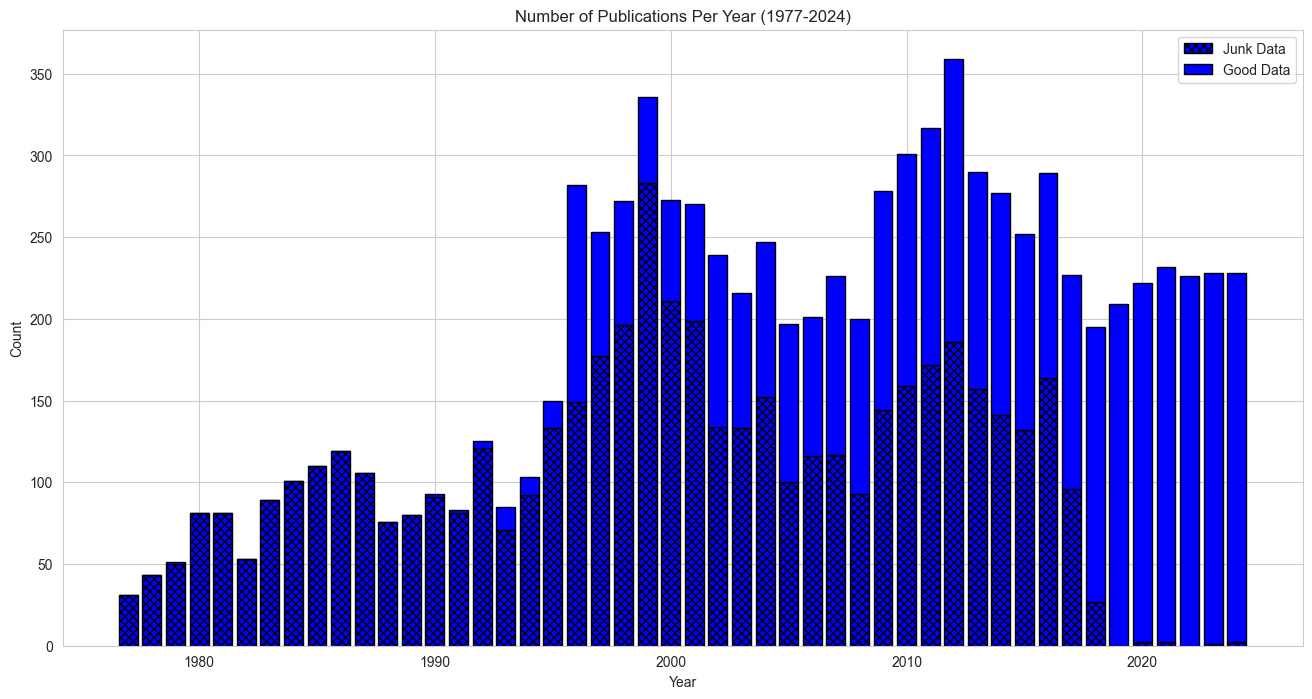

In [4]:
max_ratio = 2  # low quality / only abstract data to exclude (<7% of total translated data)
min_char = 1000  # low quality, bad OCR, or incomplete transcription / parsing

junk_df = matched_df.loc[(matched_df.len_fr < min_char) | (matched_df.len_en < min_char) | (matched_df.len_diff > max_ratio)].copy()
junk_pub_numbers = junk_df['pub_number'].to_list() 
junk_df.loc[:, 'year'] = junk_df['pub_number'].str.extract(r'(\d{4})')
junk_df['year'] = pd.to_numeric(junk_df['year'], errors='coerce')

good_df = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")].copy()
good_df.loc[:, 'year'] = good_df['pub_number'].str.extract(r'(\d{4})')
good_df['year'] = pd.to_numeric(good_df['year'], errors='coerce')

# # CONFIRMED: only fr abstract, all else en 
# preview_publication_by_row(5412)
# preview_publication_by_row(5607)
# preview_publication_by_row(4605)
# preview_publication_by_row(3580)
# preview_publication_by_row(5457)
# preview_publication_by_row(4768)

all_years = np.arange(1977, 2025)
junk_year_counts = junk_df['year'].value_counts().reindex(all_years, fill_value=0)
good_year_counts = good_df['year'].value_counts().reindex(all_years, fill_value=0)

plt.figure(figsize=(16, 8))
plt.bar(junk_year_counts.index, junk_year_counts.values, color='blue', edgecolor='black', label='Junk Data', hatch='xxxx')
plt.bar(good_year_counts.index, good_year_counts.values, color='blue', edgecolor='black', label='Good Data', bottom=junk_year_counts.values)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of Publications Per Year (1977-2024)")
plt.legend()

plt.show()

### duplicated pub_number

In [5]:
duplicated_pub_numbers = fr_eng_correlation_df['pub_number'].value_counts()[fr_eng_correlation_df['pub_number'].value_counts() > 1].index.to_list()

# SCR 2020/018 and PRO 2024/041 are fine, SSR 2002/D2-01 is broken
fr_eng_correlation_df[fr_eng_correlation_df.pub_number.isin(duplicated_pub_numbers)]

,pub_number,filename_fr,filename_en
1283,PRO 2024/041,41265841.pdf,4126583x.pdf
1284,PRO 2024/041,41265841.pdf,4126583x.pdf
8105,SCR 2020/018,40878090.pdf,40884545.pdf
8106,SCR 2020/018,40878090.pdf,40884545.pdf
8933,SSR 2002/D2-01,345791.pdf,317513.pdf
8955,SSR 2002/D2-01,345792.pdf,317694.pdf


In [6]:
preview_publication("SCR 2020/018")
preview_publication("PRO 2024/041")

,8105,8106
pub_number,SCR 2020/018,SCR 2020/018
nom,Examen scientifique des documents supplémentaires soumis du 8 octobre 2019 au 8 janvier 2020 pou...,Examen scientifique des documents supplémentaires soumis du 8 octobre 2019 au 8 janvier 2020 pou...
name,"Science Review of Additional Documents submitted October 8, 2019 - January 8, 2020 for the Final...","Science Review of Additional Documents submitted October 8, 2019 - January 8, 2020 for the Final..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2020/2020_018-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2020/2020_018-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2020/2020_018-eng.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2020/2020_018-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40878090.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40878090.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40884545.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40884545.pdf


,1283,1284
pub_number,PRO 2024/041,PRO 2024/041
nom,Compte rendu de l'examen régional par les pairs de la continuité du cadre de travail sur le hare...,Compte rendu de l'examen régional par les pairs de la continuité du cadre de travail sur le hare...
name,Proceedings of the Regional Peer Review of the Continuation of Southwest Nova Scotia/Bay of Fund...,Proceedings of the Regional Peer Review of the Continuation of Southwest Nova Scotia/Bay of Fund...
url_fr,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2024/2024_041-fra.html,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2024/2024_041-fra.html
url_en,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2024/2024_041-eng.html,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2024/2024_041-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41265841.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41265841.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4126583x.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4126583x.pdf


In [7]:
# broken pub_number 
#   it looks like these are actually "correct" 
#   there are 2 identical pub numbers, for the Apr and Nov 2002 SSR (both languages)
preview_publication("SSR 2002/D2-01")

,8933,8955
pub_number,SSR 2002/D2-01,SSR 2002/D2-01
nom,État des stocks de saumon atlantique de Terre-Neuve et du Labrador en 2001.,Mise à jour de l'état des stocks de saumon atlantique de Terre-Neuve et du Labrador en 2002.
name,Newfoundland & Labrador Atlantic Salmon Stock Status for 2001,Newfoundland & Labrador Atlantic Salmon 2002 StockStatus Update.
url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/345791.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/345792.pdf
url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/317513.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/317694.pdf
file_url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/345791.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/345792.pdf
file_url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/317513.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/317694.pdf


### Only Abstract Translated

In [8]:
abstract_only = matched_df[(matched_df.len_diff > max_ratio) & (matched_df.filename_fr == matched_df.filename_en)].copy()

abstract_only.sample(10).drop(['text_fr', 'text_en'], axis=1)

,pub_number,len_fr,len_en,len_diff,len_min,filename_fr,filename_en
766,PRO 2013/046,1567,52957,33.8,1567,351077.pdf,351077.pdf
3724,RES 2000/174,3553,26653,7.5,3553,255519.pdf,255519.pdf
2729,RES 1994/065,1574,17789,11.3,1574,170760.pdf,170760.pdf
1566,RES 1982/013,1770,21014,11.9,1770,38475.pdf,38475.pdf
4823,RES 2010/081,4618,87648,19.0,4618,341831.pdf,341831.pdf
1645,RES 1983/039,812,3960,4.9,812,25718.pdf,25718.pdf
1885,RES 1985/089,1493,31515,21.1,1493,89380.pdf,89380.pdf
25,PRO 1996/001,0,149678,999.0,0,197005.pdf,197005.pdf
315,PRO 2005/003,3442,36628,10.6,3442,315758.pdf,315758.pdf
694,PRO 2012/026,2730,37840,13.9,2730,346675.pdf,346675.pdf


### likley bad references on website

In [9]:
# TODO: could also check poor correlation between matches, ie, if average correlation is below a threshold, it's likely a false positive (NEED CORPUS FOR THIS)

bad_weblinks = matched_df[(matched_df.len_diff > max_ratio) & (matched_df.filename_fr != matched_df.filename_en)].copy()

for pub_number in bad_weblinks.pub_number.to_list():
    preview_publication(pub_number)

,737
pub_number,PRO 2012/059
nom,"Compte rendu de l'évaluation nationale des risques posés par la moule zébrée, la moule quagga et..."
name,"Proceedings of the National Risk Assessment of Zebra Mussel, Quagga Mussel and Dark Falsemussel;..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348617.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348616.pdf


,3642
pub_number,RES 2000/041
nom,NaN
name,"Status of Atlantic salmon (Salmo salar L.) In Indian bay Brook, Middle Brook, and Terra Nova Riv..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf


,5275
pub_number,RES 2013/002
nom,Mise à jour de l'estimation de biomasse et d'abondance de la crevette nordique (Pandalus boreali...
name,Update of the estimation of northern shrimp (Pandalus borealis) biomass and abundance from the t...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348703.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348701.pdf


,6017
pub_number,RES 2020/066
nom,Abondance de la population et caractéristiques biologiques du Dolly Varden (Salvelinus malma mal...
name,Population abundance and biological characteristics of Dolly Varden (Salvelinus malma malma) fro...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2020/2020_066-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2020/2020_066-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40953348.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40953324.pdf


,6212
pub_number,RES 2023/026
nom,"Examen pré-COSEPAC du saumon atlantique (Salmo salar) anadrome Canada, partie 1 : Unités désigna..."
name,"Pre-COSEWIC Review of Anadromous Atlantic Salmon (Salmo salar) in Canada, Part 1: Designatable U..."
url_fr,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-fra.html
url_en,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117748.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117554.pdf


,6767
pub_number,SAR 2010/070
nom,Directives pour l'utilisation de méthodes mises à jour pour l'évaluation des règles de pêche au ...
name,Guidelines for applying updated methods for assessing harvest rules for Fraser River sockeye sal...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343603.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343602.pdf


,6843
pub_number,SAR 2011/067
nom,"Avis scientifique découlant de l'évaluation du risque d'introduction, par les navires, d'espèces..."
name,Science advice from the risk assessment for ship-mediated introductions of aquatic nonindigenous...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346314.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346313.pdf


,6922
pub_number,SAR 2012/045
nom,"Évaluation de l'inconnu (Stenodus leucichthys) de la rivière Buffalo, Grand lac des Esclaves, Te..."
name,"Assessment of Buffalo River Inconnu (Stenodus leucichthys) Great Slave Lake, Northwest Territori..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf


,7062
pub_number,SAR 2014/042
nom,Évaluation du stock de goberge dans la sous-division 3Ps
name,Stock Assessment on Subdivision 3Ps Pollock
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2014/2014_042-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2014/2014_042-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/352153.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/364309.pdf


,7761
pub_number,SCR 2012/041
nom,Probabilité que les stocks de crevette tachetée (Pandalus platyceros) se trouvant dans les zones...
name,Probability of spot prawn (Pandalus platyceros) stocks in fall survey areas in British Columbia ...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf


,7839
pub_number,SCR 2014/033
nom,Évaluation de la possibilité de rouvrir les zones de fermeture A et B du Grand Lac des esclaves
name,Assessment of the potential to re-open Great Slave Lake Closure Zones A and B
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/scr-rs/2014/2014_033-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2014/2014_033-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363608.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363607.pdf


,8538
pub_number,SSR 1997/G3-02
nom,"État du phytoplancton, du zooplancton et du krill sur le plateau néo-écossais en 1996"
name,"State of phytoplankton, zooplankton and krill on the Scotian Shelf in 1996"
url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/219497.pdf
url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/219073.pdf
file_url_fr,http://waves-vagues.dfo-mpo.gc.ca/Library/219497.pdf
file_url_en,http://waves-vagues.dfo-mpo.gc.ca/Library/219073.pdf


# check corpus to make sure it's reasonable (doesn't look great)

In [10]:
# also check matched_df pub_number counts for minimal entries (ie, very few strong matches)
corpus_df = pd.read_pickle("matched_data.pickle")

corpus_df = pd.merge(
    corpus_df,
    matched_df.drop_duplicates('pub_number', keep="first"),
    on="pub_number",
    how="left"
)

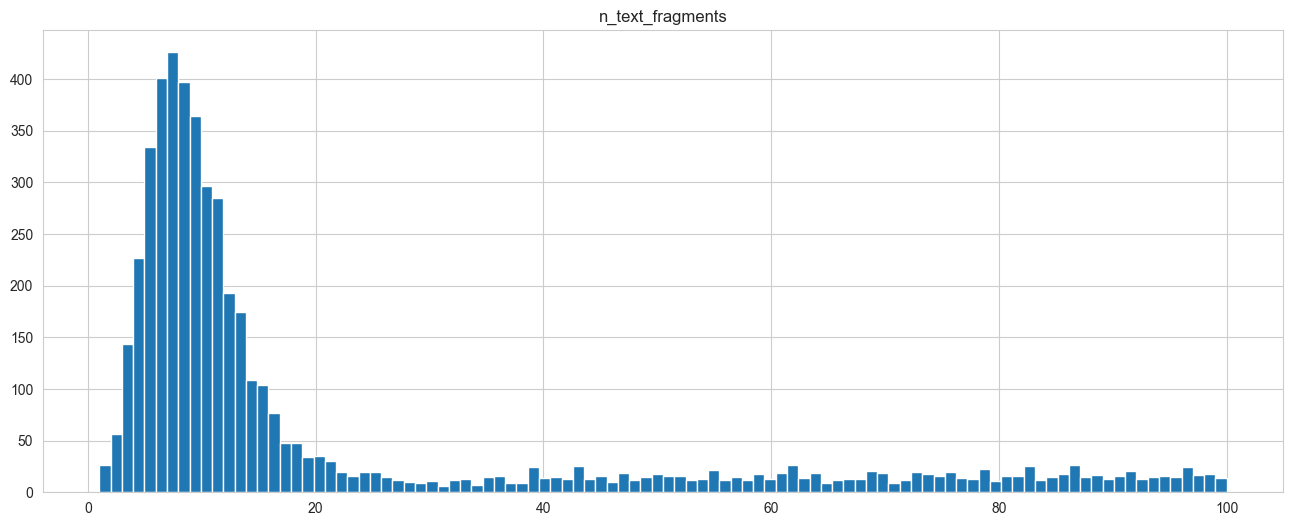

In [11]:
corpus_value_counts = pd.DataFrame(corpus_df.pub_number.value_counts())
corpus_value_counts.columns = ['n_text_fragments']
corpus_value_counts[corpus_value_counts.n_text_fragments <= 100].hist(bins=100, figsize=(16, 6));

In [12]:
pub_numbers_with_bad_translations = corpus_value_counts[corpus_value_counts.n_text_fragments < 20].index.to_list()

len(pub_numbers_with_bad_translations)

3745

In [13]:
random.sample(pub_numbers_with_bad_translations, 10)

['PRO 2017/046',
 'RES 2014/045',
 'RES 1996/035',
 'RES 2010/023',
 'RES 1996/028',
 'RES 2016/093',
 'RES 2005/078',
 'RES 1986/036',
 'RES 1992/038',
 'RES 2005/001']

In [14]:
preview_publication('RES 1997/060')
preview_publication('RES 1995/075')
preview_publication('RES 1997/046')
preview_publication('RES 2012/037')
preview_publication('PRO 2015/065')
preview_publication('RES 1987/035')
preview_publication('RES 1988/071')
preview_publication('RES 2002/022')
preview_publication('RES 1999/129')
preview_publication('RES 1985/101')

,3131
pub_number,RES 1997/060
nom,NaN
name,Trends in abundance of short-finned squid (Illex illecebrosus) and environmental conditions in t...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_060-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_060-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/212620.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/212620.pdf


,2864
pub_number,RES 1995/075
nom,NaN
name,Analysis of replacement in eight northwest Atlantic cod stocks (11 p.)
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1995/1995_075-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1995/1995_075-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/184322.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/184322.pdf


,3117
pub_number,RES 1997/046
nom,NaN
name,Results of 1996 research surveys of sea scallop abundance in areas near Grand Manan Island and C...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_046-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1997/1997_046-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/228361.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/228361.pdf


,5124
pub_number,RES 2012/037
nom,"Résultats des relevés aériens du narval (Monodon monoceros) dans le nord de la baie d'Hudson, ao..."
name,"Results of narwhal (Monodon monoceros) aerial surveys in northern Hudson Bay, August 2011"
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2012/2012_037-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2012/2012_037-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347183.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347183.pdf


,896
pub_number,PRO 2015/065
nom,Compte rendu de l'examen par les pairs de la région du Pacifique sur l' Évaluation des stocks de...
name,Proceedings of the Pacific regional peer review on Stock assessment for Pacific Ocean Perch in A...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/pro-cr/2015/2015_065-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/pro-cr/2015/2015_065-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/362437.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/362437.pdf


,2087
pub_number,RES 1987/035
nom,NaN
name,Redfish (Sebastes spp.) in Management Unit 4VWX: An assessment of present stock status
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1987/1987_035-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1987/1987_035-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/102280.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/102280.pdf


,2230
pub_number,RES 1988/071
nom,NaN
name,Assessment of Divisions 4VWX and Subarea 5 pollock (Pollachius virens)
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1988/1988_071-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1988/1988_071-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/110800.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/110800.pdf


,3959
pub_number,RES 2002/022
nom,Effort de pêche du homard sur le littoral extérieur de la Nouvelle-Écosse en 1983 par opposition...
name,Lobster Fishing Effort on the Outer Coast of Nova Scotia 1983 versus 1998
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_022-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_022-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/264717.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/264717.pdf


,3513
pub_number,RES 1999/129
nom,NaN
name,Run size forecasts for Fraser River sockey and pink salmon in 1999.
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1999/1999_129-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1999/1999_129-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/238466.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/238466.pdf


,1925
pub_number,RES 1985/101
nom,NaN
name,Assessment of the Nepisiguit River salmon stock in 1984
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1985/1985_101-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1985/1985_101-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/89403.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/89403.pdf


In [15]:
(
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr == corpus_df.filename_en)].shape[0], 
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr != corpus_df.filename_en)].shape[0]
 )

(32115, 213)

In [16]:
# total pub numbers in corpus, # bad translations, # bad translations with different files
(
    corpus_df.pub_number.nunique(), 
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr == corpus_df.filename_en)].pub_number.nunique(),
    corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr != corpus_df.filename_en)].pub_number.nunique()
)
# all, abstract only, messed up?

(7796, 3727, 18)

In [17]:
pub_numbers_abstract_only = corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr == corpus_df.filename_en)].pub_number.to_list()
pub_numbers_messed_up = corpus_df[(corpus_df.pub_number.isin(pub_numbers_with_bad_translations)) & (corpus_df.filename_fr != corpus_df.filename_en)].pub_number.to_list()

In [18]:
random_pub_number = random.choice(pub_numbers_abstract_only)

print(random_pub_number)
preview_publication(random_pub_number)
corpus_df[corpus_df.pub_number == random_pub_number][['fr', 'en']]

RES 2008/047


,4654
pub_number,RES 2008/047
nom,"La morue du Nord (Gadus morhua), 16 ans après le moratoire : nouvelles données provenant du marq..."
name,Northern cod (Gadus morhua) 16 years after the moratorium: new information from tagging and acou...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2008/2008_047-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2008/2008_047-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/335340.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/335340.pdf


,fr,en
202336,La présente série documente les bases scientifiques des évaluations des ressources halieutiques ...,Porter Science Branch Fisheries and Oceans Canada PO Box 5667 St
202337,iv RÉSUMÉ Nous avons employé une approche combinée de marquage et de télémétrie acoustique pour ...,John s NL A1C 5X1 iii ABSTRACT A combined tagging and acoustic telemetry approach was used to in...
202338,"Après une étude à petite échelle, le relâchement de grands nombres de morues ( 100 par an) munie...","Following a pilot scale study, we released large numbers of cod ( 100 per year) with surgically ..."
202339,"Par ailleurs, grâce à un réseau de récepteurs installés le long de la côte nord-est de Terre-Neu...",We also deployed arrays of receivers along the northeast coast of NL to investigate migration pa...
202340,Les morues munies d un émetteur ont été capturées par des pêcheurs dans des proportions de 10 en...,"Ten percent of telemetred SS cod were captured in the fishery in 2006 and 9 in 2007, from report..."
202341,Les estimations directes du taux minimal de survie de deux groupes de morues munies d un émetteu...,Direct estimates of the minimum survival rate of two groups of telemetred cod were 80 (from 19 M...
202342,Certaines morues relâchées au large de l île de Twillingate et dans le détroit de Newman ont pas...,Some cod released off Twillingate and in Newman Sound over-wintered in the deep inlets of inner ...
202343,Les résultats soutiennent la structure des stocks révisée qui est utilisée dans les évaluations ...,"The results support the revised stock structure used in assessments of northern cod since 2005, ..."


In [19]:
# RES 2011/097: why didn't this get excluded? len_diff = 17???

matched_df[matched_df.pub_number == 'RES 2011/097'].T

,4977
pub_number,RES 2011/097
text_fr,Secrétariat canadien de consultation scientifique. La présente série documente les fondements \...
text_en,Canadian Science Advisory Secretariat. This series documents the scientific basis for the \neva...
len_fr,1941
len_en,33080
len_diff,17.0
len_min,1941
filename_fr,344946.pdf
filename_en,344946.pdf


In [20]:
row = fr_eng_correlation_df[fr_eng_correlation_df.pub_number == 'RES 2011/097']
pub_number = 'RES 2011/097'

filename_fr, filename_en = row['filename_fr'].values[0], row['filename_en'].values[0]

if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
    print('continue')

fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
if fr_link == None:
    print('continue')

if filename_fr == filename_en:
    text_fr, text_en = extract_both_languages_from_single_file(fr_link, language_classifier)
else:
    en_link = get_json_file_link(parsed_docs_folder, filename_en) 
    if en_link == None:
        print('continue')
    text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, language_classifier)

# low-quality text criteria
len_fr, len_en = len(text_fr), len(text_en)
if len_fr == 0 or len_en == 0:
    print('continue')
elif 1 / max_ratio > len(text_fr) / len(text_en) > max_ratio:
    print('continue')
elif len(text_fr) < min_char or len(text_en) < min_char:
    print('continue')

temp_list_of_correlated_text = correlate_and_clean_text(text_fr, text_en, pub_number, sentence_encoder)

In [21]:
# the data is fine, but why did the second last continue never trigger? 
# -> messed up inequality, none excluded for len ratio

for x, y, z in temp_list_of_correlated_text:
    print(x)
    print('\t', y)
    print('\t\t', z)
    print()

RES 2011/097
	 Les documents qu elle contient ne doivent pas être considérés comme des énoncés définitifs sur les sujets traités, mais plutôt comme des rapports d étape sur les études en cours
		 As such, it addresses the issues of the day in the time frames required and the documents it contains are not intended as definitive statements on the subjects addressed but rather as progress reports on ongoing investigations

RES 2011/097
	 Les estimés d abondance de géniteurs se situent en moyenne à 50 000 (16 200 à 92 160 écart annuel) poissons durant les cinq dernières années (2006 à 2010) et à 35 000 (12 550 à 92 160 écart annuel) poissons durant la dernière décennie (2001 à 2010)
		 Estimates of spawner abundance have averaged 50,000 (16,200 to 92,160 annual range) over the last 5 years (2006 to 2010) and 35,000 (12,550 to 92,160) over the last decade (2001 to 2010)

RES 2011/097
	 L estimé de mortalité totale pour les bar rayé adultes de cette population demeure élevé (0,47) mais on cr